In [30]:
!pip install tensorflow matplotlib numpy scikit-learn


In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split


In [4]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar -xvzf speech_commands_v0.02.tar.gz


Streaming output truncated to the last 5000 lines.
./on/fc3ba625_nohash_0.wav
./on/db9d52d2_nohash_0.wav
./on/72242187_nohash_4.wav
./on/b0f5b16d_nohash_0.wav
./on/d9aa8c90_nohash_1.wav
./on/525eaa62_nohash_0.wav
./on/42e3f068_nohash_0.wav
./on/94d370bf_nohash_4.wav
./on/bf8d5617_nohash_0.wav
./on/e2b7d6d6_nohash_2.wav
./on/89ed36ab_nohash_0.wav
./on/30276d03_nohash_1.wav
./on/364c0853_nohash_0.wav
./on/7cbf645a_nohash_0.wav
./on/c98bbbd3_nohash_2.wav
./on/9a7c1f83_nohash_5.wav
./on/3589bc72_nohash_0.wav
./on/3ae5c04f_nohash_0.wav
./on/adc216c5_nohash_2.wav
./on/c50f55b8_nohash_15.wav
./on/324210dd_nohash_2.wav
./on/c120e80e_nohash_2.wav
./on/69086eb0_nohash_0.wav
./on/dce05676_nohash_1.wav
./on/435695e3_nohash_1.wav
./on/179a61b7_nohash_1.wav
./on/f5341341_nohash_0.wav
./on/91b03183_nohash_0.wav
./on/96d8bb6f_nohash_2.wav
./on/6a1908f8_nohash_0.wav
./on/6ace4fe1_nohash_1.wav
./on/84d1e469_nohash_1.wav
./on/ba676390_nohash_0.wav
./on/1dc86f91_nohash_4.wav
./on/3a929277_nohash_2.wav
./o

In [32]:
DATASET_PATH = '/content'
CLASSES = ['yes', 'no', 'happy']  # 'happy' acts as 'Don't Know'


In [26]:
!ls /content


_background_noise_  four     on				   three
backward	    go	     one			   tree
bed		    happy    README.md			   two
bird		    house    right			   up
cat		    learn    sample_data		   validation_list.txt
dog		    left     seven			   visual
down		    LICENSE  sheila			   wow
eight		    marvin   six			   yes
five		    nine     speech_commands_v0.02.tar.gz  zero
follow		    no	     stop
forward		    off      testing_list.txt


In [33]:
import tensorflow as tf
import numpy as np

def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    audio, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)

    # Convert to numpy
    audio_np = audio.numpy()
    sr = int(sample_rate.numpy())

    # If not 16 kHz, resample manually
    if sr != 16000:
        duration = len(audio_np) / sr
        new_length = int(16000 * duration)
        audio_np = np.interp(np.linspace(0, len(audio_np), new_length),
                             np.arange(len(audio_np)),
                             audio_np)

    return tf.convert_to_tensor(audio_np, dtype=tf.float32)


In [34]:
files, labels = [], []
for label in CLASSES:
    path = os.path.join(DATASET_PATH, label)
    for f in os.listdir(path)[:700]:  # subset for speed
        if f.endswith('.wav'):
            files.append(os.path.join(path, f))
            labels.append(label)

label_to_index = {name: i for i, name in enumerate(CLASSES)}
y = np.array([label_to_index[label] for label in labels])

train_files, test_files, y_train, y_test = train_test_split(files, y, test_size=0.2, random_state=42)


In [41]:
def preprocess(filename, label):
    audio = load_wav_16k_mono(filename)

    # Ensure all audio clips are exactly 16000 samples (1 sec)
    audio = audio[:16000]  # trim longer clips
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)

    # Convert to spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Ensure consistent size (pad or trim)
    desired_width = 128
    current_width = tf.shape(spectrogram)[0]
    spectrogram = spectrogram[:desired_width, :]
    spectrogram = tf.cond(current_width < desired_width,
                          lambda: tf.pad(spectrogram, [[0, desired_width - current_width], [0, 0]]),
                          lambda: spectrogram)

    spectrogram = tf.expand_dims(spectrogram, -1)
    label = tf.cast(label, tf.int32)
    return spectrogram, label


In [48]:
def make_dataset(files, labels):
    def wrap_preprocess(filename, label):
        spectrogram, label = tf.py_function(preprocess, [filename, label], [tf.float32, tf.int32])
        spectrogram.set_shape((128, 129, 1))  # explicitly define shape
        label.set_shape(())
        return spectrogram, label

    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    dataset = dataset.map(wrap_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = make_dataset(train_files, y_train)
test_ds  = make_dataset(test_files, y_test)


In [43]:
sample_audio, sample_label = next(iter(train_ds))
print("Spectrogram shape:", sample_audio.shape)
print("Label:", sample_label[0].numpy())


Spectrogram shape: (32, 128, 129, 1)
Label: 2


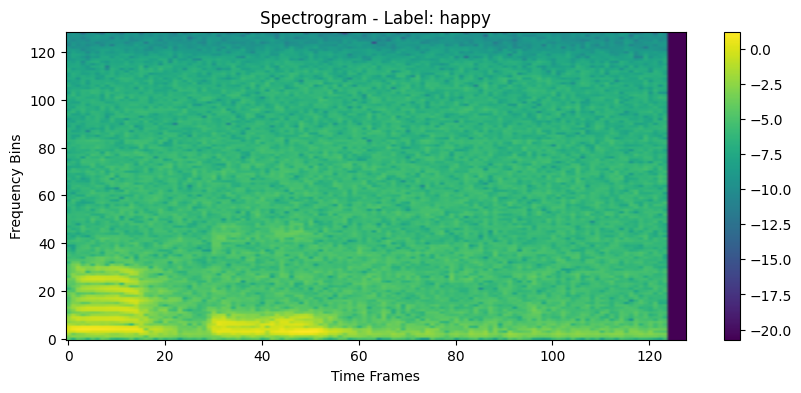

In [44]:
def display_spectrogram(spectrogram, label):
    spectrogram = tf.squeeze(spectrogram[0], axis=-1)
    plt.figure(figsize=(10, 4))
    plt.imshow(np.log(spectrogram + 1e-9).T, aspect='auto', origin='lower')
    plt.title(f"Spectrogram - Label: {CLASSES[label]}")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.colorbar()
    plt.show()

display_spectrogram(sample_audio, sample_label[0].numpy())


In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 129, 1)),  # fully-defined input
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
])


In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=10)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 648ms/step - accuracy: 0.6325 - loss: 0.8868 - val_accuracy: 0.8452 - val_loss: 0.4737
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 663ms/step - accuracy: 0.8922 - loss: 0.3257 - val_accuracy: 0.9167 - val_loss: 0.3468
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 660ms/step - accuracy: 0.9486 - loss: 0.1837 - val_accuracy: 0.9167 - val_loss: 0.3149
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 671ms/step - accuracy: 0.9616 - loss: 0.1112 - val_accuracy: 0.9286 - val_loss: 0.3392
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.9758 - loss: 0.0793 - val_accuracy: 0.9262 - val_loss: 0.3548
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 744ms/step - accuracy: 0.9845 - loss: 0.0599 - val_accuracy: 0.9143 - val_loss: 0.4192
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 659ms/step - accuracy: 0.9826 - loss: 0.0546 - val_accuracy: 0.9286 - val_loss: 0.3699
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 771ms/step - accuracy: 0.9945 - loss: 0.0253 - val_accu

In [50]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9501 - loss: 0.2644
Test Accuracy: 94.05%


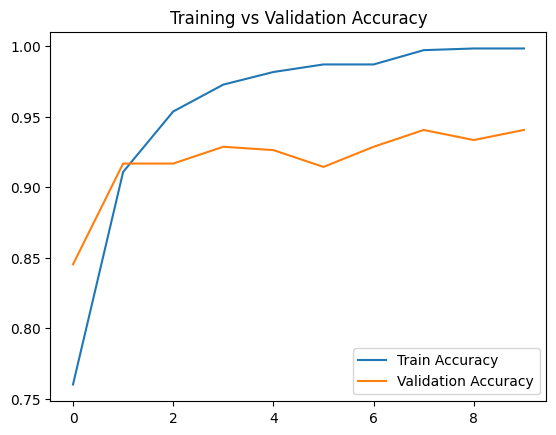

In [51]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()
